## Imports

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Modeling/").resolve()
sys.path.append(str(scripts_path))

In [7]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
from model_scripts.feature_extraction import *
from model_scripts.executions import *
import torch.nn.functional as F
from Experimentation.expt_scripts.sugarcontent_data_processing import *
from Experimentation.expt_scripts.expt_plots import *
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from Experimentation.expt_scripts.regression import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Model prep: Conv3D Autoencoder with Temporal Encodings

### Load saved 3D Conv Autoencoder trained with temporal data
Redefine the architecture because the object needs to be created to load saved checkpoints

In [9]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, 7, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, 7, 2)
        date_embeddings_tensor = date_embeddings_tensor.permute(0, 2, 1)                                # Shape: (B, 2, 7)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, 7, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, 7, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, 7, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, 7, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

## Data Prep: MVI

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 3, 64, 64)

Bands: NDVI, EVI, MSI

In [10]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, date_emb_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'mvi_add', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, date_emb_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'mvi_add', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

/home/k64835/Master-Thesis-SITS/Data-Preprocessing/scripts/temporal_chanel_refinement.py:440: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((nir + red) != 0, (nir - red) / (nir + red), 0)
/home/k64835/Master-Thesis-SITS/Data-Preprocessing/scripts/temporal_chanel_refinement.py:443: RuntimeWarning: invalid value encountered in divide
  msi = np.where(nir != 0, swir / nir, 0)


(torch.Size([1228, 7, 3, 64, 64]), torch.Size([48, 7, 3, 64, 64]))

Create Sub-Patches

In [11]:
train_subpatches, train_subpatch_coords, train_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_train, field_numbers_train, date_emb_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords, eval_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_eval, field_numbers_eval, date_emb_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([33128, 7, 3, 4, 4]), torch.Size([1197, 7, 3, 4, 4]))

Get field numbers and co-ordinates as string

In [12]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
eval_coord_dataloader[0], len(eval_coord_dataloader), len(train_coord_dataloader)

('1168039.0_20_24', 1197, 33128)

Split Unlabeled data into 'train' and 'test' and create  Data Loaders


The data loader function for MAE is used since it is designed to take temporal encodings additionally

In [14]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers, train_date_embeddings, test_date_embeddings = train_test_split(
    train_subpatches, train_coord_dataloader, train_subpatch_date_emb, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train_mvi = create_data_loader_mae(train_subpatches_dl, train_field_numbers, train_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test_mvi = create_data_loader_mae(test_subpatches, test_field_numbers, test_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval_mvi = create_data_loader_mae(eval_subpatches, eval_coord_dataloader, eval_subpatch_date_emb, mae=False, batch_size=config.ae_batch_size, shuffle=False)

## Data Prep: B4

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 4, 64, 64)

Bands: Red, Blue, NIR1, SWIR1

In [15]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, date_emb_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b4_add', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, date_emb_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b4_add', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([1228, 7, 4, 64, 64]), torch.Size([48, 7, 4, 64, 64]))

Create Sub-Patches

In [16]:
train_subpatches, train_subpatch_coords, train_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_train, field_numbers_train, date_emb_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords, eval_subpatch_date_emb = non_overlapping_sliding_window_with_date_emb(patch_tensor_eval, field_numbers_eval, date_emb_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([33128, 7, 4, 4, 4]), torch.Size([1197, 7, 4, 4, 4]))

Get field numbers and co-ordinates as string

In [17]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
eval_coord_dataloader[0], len(eval_coord_dataloader), len(train_coord_dataloader)

('1168039.0_20_24', 1197, 33128)

Split Unlabeled data into 'train' and 'test' and create  Data Loaders


The data loader function for MAE is used since it is designed to take temporal encodings additionally

In [18]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers, train_date_embeddings, test_date_embeddings = train_test_split(
    train_subpatches, train_coord_dataloader, train_subpatch_date_emb, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train_b4 = create_data_loader_mae(train_subpatches_dl, train_field_numbers, train_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test_b4 = create_data_loader_mae(test_subpatches, test_field_numbers, test_date_embeddings, mae=False, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval_b4 = create_data_loader_mae(eval_subpatches, eval_coord_dataloader, eval_subpatch_date_emb, mae=False, batch_size=config.ae_batch_size, shuffle=False)

## Model Training

### MVI

In [20]:
device = 'cuda'
epochs = 50
lr = 0.001
vae_lr=0.001
vae_optimizer = 'Adam'
momentum = 0.9
latent_dim = 32
channels = 3
time_steps = 7
optimizer = 'Adam'
patch_size = config.subpatch_size

In [24]:
model_names = ["3D_AE_MVI"]
model_objs = [Conv3DAutoencoder]  # Replace with your model constructors
train_loss = {}
test_loss = {}
metrics = {}

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train_mvi,
        dataloader_test=dataloader_test_mvi,
        dataloader_eval=dataloader_eval_mvi,
        channels=channels, 
        timestamps=time_steps,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path,
        non_temp=False
    )
    train_loss[name] = avg_test_loss
    test_loss[name] = avg_test_loss
    metrics[name] = avg_metrics
    print("Model ",name," trained")


Model  3D_AE_MVI  trained


### B4

In [25]:
device = 'cuda'
epochs = 50
lr = 0.001
vae_lr=0.001
vae_optimizer = 'Adam'
momentum = 0.9
latent_dim = 32
channels = 4
time_steps = 7
optimizer = 'Adam'
patch_size = config.subpatch_size

In [27]:
model_names = ["3D_AE_B4"]
model_objs = [Conv3DAutoencoder]  # Replace with your model constructors

for name, obj in zip(model_names, model_objs):
    avg_train_loss, avg_test_loss, avg_metrics = train_model_multiple_runs_with_metrics(
        model_name=name,
        model_class=obj,
        dataloader_train=dataloader_train_b4,
        dataloader_test=dataloader_test_b4,
        dataloader_eval=dataloader_eval_b4,
        channels=channels, 
        timestamps=time_steps,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        vae_lr=vae_lr,
        vae_optimizer=vae_optimizer,
        momentum=momentum,
        device=device,
        config=config,
        output_dir=config.results_json_path,
        non_temp=False
    )
    train_loss[name] = avg_test_loss
    test_loss[name] = avg_test_loss
    metrics[name] = avg_metrics
    print("Model ",name," trained")


Model  3D_AE_B4  trained


## Results and Comparison with B10 Data

Run this to reproduce accuracy tables.

The files with results of 3 executions and avg results are saved already at /Modeling/Results.

In [8]:
model_names = ['3D_AE_temporal_addition', '3D_AE_MVI', '3D_AE_B4']
df_loss, df_accuracy, df_recall, df_f1 = compile_results_table_with_metrics(model_names, output_dir=config.results_json_path)

In [9]:
df_f1

,Model,F1 Run 1,F1 Run 2,F1 Run 3,F1-score Avg
0,3D_AE_temporal_addition,75.32,75.32,75.00,75.213333
1,3D_AE_MVI,70.59,63.41,58.97,64.323333
2,3D_AE_B4,75.32,75.95,55.26,68.843333


In [30]:
df_accuracy

,Model,Accuracy Run 1,Accuracy Run 2,Accuracy Run 3,Accuracy Avg
0,3D_AE_temporal_addition,68.85,68.85,68.85,68.850000
1,3D_AE_MVI,59.02,50.82,47.54,52.460000
2,3D_AE_B4,68.85,68.85,44.26,60.653333


In [31]:
df_recall

,Model,Recall Run 1,Recall Run 2,Recall Run 3,Recall Avg
0,3D_AE_temporal_addition,82.86,82.86,77.14,80.953333
1,3D_AE_MVI,85.71,74.29,65.71,75.236667
2,3D_AE_B4,82.86,85.71,60.00,76.190000


### Losses

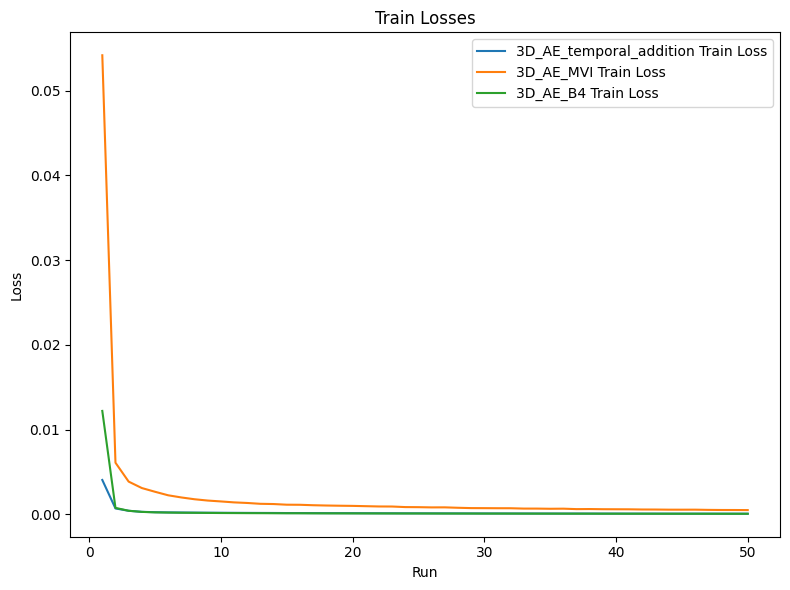

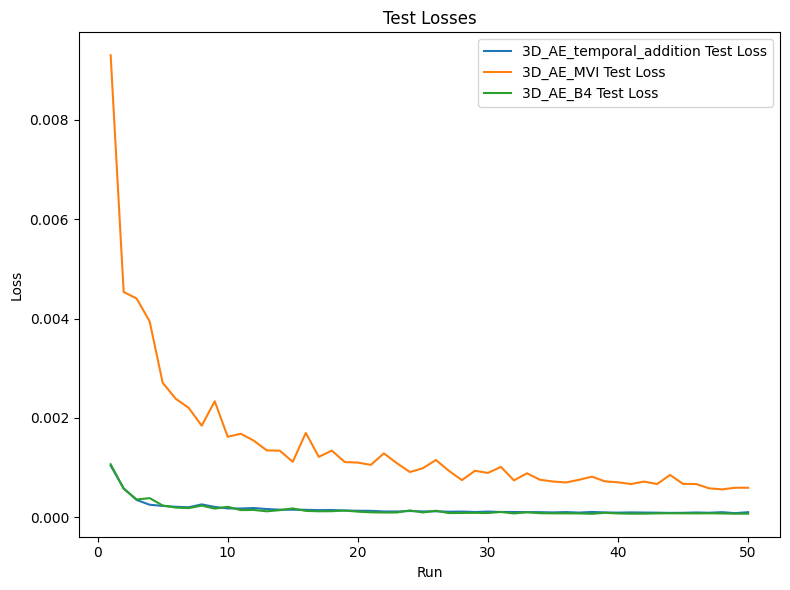

In [32]:
train_loss, test_loss = load_avg_losses(model_names, output_dir='/home/k64835/Master-Thesis-SITS/Modeling/Results')
plot_losses_ae(train_loss, test_loss)